In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_step
%store -r Y_motion_step
print(X_motion_step.shape)
print(Y_motion_step.shape)

(148884, 38)
(148884, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
# Entries where FL foot is swinging
idx_fl_swinging = np.where(X_motion_step[:, 25] == 1)[0]
X_motion_step_FL = X_motion_step[idx_fl_swinging]
Y_motion_step_FL = Y_motion_step[idx_fl_swinging]

In [14]:
X_motion_step_FL[0, 24:34]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.01586381,
       -0.00457941,  0.02445424,  0.00146174,  0.        ,  0.        ])

In [55]:
# CoM velocity when forward velocity applied
motion_idx = np.where(X_motion_step_FL[:, 0] > 0)[0]
len(motion_idx)

14988

In [76]:
fwd_idx = np.where(X_motion_step_FL[:, 0] > 0)[0]
left_idx = np.where(X_motion_step_FL[:, 1] > 0)[0]
right_idx = np.where(X_motion_step_FL[:, 1] < 0)[0]
clock_idx = np.where(X_motion_step_FL[:, 5] < 0)[0]
count_idx = np.where(X_motion_step_FL[:, 5] < 0)[0]

In [84]:
print(len(np.where(X_motion_step_FL[fwd_idx, 34] < 0)))
print(len(np.where(X_motion_step_FL[left_idx, 35] < 0)))
print(len(np.where(X_motion_step_FL[right_idx, 35] > 0)))

1
1
1


In [58]:
for x in motion_idx[:100]:
    print(f'Command: {X_motion_step_FL[x, 0]}. FL step: {Y_motion_step_FL[x, 0]}. DT: {X_motion_step_FL[x, -1]}. FL velocity (x): {Y_motion_step_FL[x, 0]/X_motion_step_FL[x, -1]}')

Command: 0.1. FL step: 0.07464571297168732. DT: 0.3340747356414795. FL velocity (x): 0.22344016176007753
Command: 0.1. FL step: 0.060104385018348694. DT: 0.3008713722229004. FL velocity (x): 0.1997677099495541
Command: 0.1. FL step: 0.060781627893447876. DT: 0.296616792678833. FL velocity (x): 0.20491634119737867
Command: 0.1. FL step: 0.054504647850990295. DT: 0.30576372146606445. FL velocity (x): 0.1782574060442928
Command: 0.15000000000000002. FL step: 0.06848326325416565. DT: 0.31066370010375977. FL velocity (x): 0.22044179358995808
Command: 0.15000000000000002. FL step: 0.09516866505146027. DT: 0.3691442012786865. FL velocity (x): 0.2578089124028049
Command: 0.15000000000000002. FL step: 0.08363787829875946. DT: 0.34530067443847656. FL velocity (x): 0.24221753529665208
Command: 0.15000000000000002. FL step: 0.08625790476799011. DT: 0.3507246971130371. FL velocity (x): 0.2459419181997028
Command: 0.15000000000000002. FL step: 0.08774815499782562. DT: 0.29979777336120605. FL velocit

In [50]:
for x in motion_idx[:100]:
    print(f'Command: {X_motion_step[x, 1]}. CoM velocity (x): {X_motion_step[x, 34]}. CoM velocity (y): {X_motion_step[x, 35]}.')

Command: -0.1. CoM velocity (x): 0.0051085630270957605. CoM velocity (y): -0.0790496965985377.
Command: -0.1. CoM velocity (x): -0.0006171932431747319. CoM velocity (y): -0.10630163411144769.
Command: -0.1. CoM velocity (x): 0.025425627626984592. CoM velocity (y): -0.1307456275924474.
Command: -0.1. CoM velocity (x): 0.007924635134314888. CoM velocity (y): -0.0802641432302122.
Command: -0.1. CoM velocity (x): 0.024033085806798117. CoM velocity (y): -0.1283525273789093.
Command: -0.1. CoM velocity (x): 0.0077544619649974. CoM velocity (y): -0.09169678132039508.
Command: -0.1. CoM velocity (x): 0.023860853919836042. CoM velocity (y): -0.11083962445825297.
Command: -0.1. CoM velocity (x): 0.005404698378536007. CoM velocity (y): -0.11609200690837801.
Command: -0.1. CoM velocity (x): 0.020252329551486425. CoM velocity (y): -0.13203024136242375.
Command: -0.15000000000000002. CoM velocity (x): 0.00756483468608427. CoM velocity (y): -0.14874999824894167.
Command: -0.15000000000000002. CoM vel

In [86]:
Y_motion_step_FL[:100, 0]

array([0.07464571, 0.06010439, 0.06078163, 0.05450465, 0.06848326,
       0.09516867, 0.08363788, 0.0862579 , 0.08774815, 0.052808  ,
       0.0544083 , 0.05372943, 0.06195404, 0.0687784 , 0.08469264,
       0.08332793, 0.09989096, 0.09243038, 0.05933575, 0.05358246,
       0.05847915, 0.05842283, 0.05954041, 0.08378454, 0.09065428,
       0.08591603, 0.0970754 , 0.07003787, 0.05217314, 0.05968502,
       0.06025758, 0.05286194, 0.08810744, 0.09398463, 0.0959523 ,
       0.08868574, 0.07720284, 0.05756426, 0.0624297 , 0.05377547,
       0.0603686 , 0.09169602, 0.08689214, 0.08928135, 0.09183738,
       0.08717282, 0.05301684, 0.05561276, 0.0527551 , 0.05350466,
       0.08151005, 0.08473858, 0.09451021, 0.09218401, 0.09860574,
       0.05418505, 0.05793175, 0.05589502, 0.05422227, 0.06791385,
       0.09737831, 0.08854353, 0.0855709 , 0.08459334, 0.06744415,
       0.05369668, 0.05349596, 0.05405936, 0.06009391, 0.08743665,
       0.08254763, 0.08471991, 0.09536809, 0.07636493, 0.05420

In [91]:
#for x in range(1, 100):
#    print(f'Motion: {X_motion_step_FL[x, 0]}. Velocity (FL) {Y_motion_step_FL[x,0]/(X_motion_step_FL[x, -1]-X_motion_step_FL[x-1, -1])}. Velocity (RR) {Y_motion_step_FL[x,6]/(X_motion_step_FL[x, -1]-X_motion_step_FL[x-1, -1])}.')

## Predict FL foot -> x

In [36]:
X_motion_step_FL[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.35253631e-02, -5.45018454e-03,
        1.90322078e-37, -5.57888703e-24, -4.46281599e-23,  9.45164094e-02,
        1.59093827e-01,  1.32301375e-01, -3.42030436e-01,  2.06204250e-01,
       -1.36616319e-01, -3.38554084e-01, -2.68098682e-01,  1.39270037e-01,
       -3.41048896e-01, -2.74800837e-01, -1.31081313e-01, -3.37453157e-01,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.58638060e-02, -4.57940996e-03,  2.44542360e-02,  1.46174431e-03,
        0.00000000e+00,  0.00000000e+00,  1.63111719e+09])

### Linear Regression

In [31]:
X_motion_step[idx_fl_swinging-1, -1][:100]

array([0.17949653, 0.34110284, 0.35154986, 0.34302187, 0.3473804 ,
       0.30436182, 0.30151248, 0.29698682, 0.34815049, 0.27096629,
       0.31960869, 0.308496  , 0.31018829, 0.25286603, 0.35173821,
       0.34124327, 0.39480495, 0.32067728, 0.2966857 , 0.3287065 ,
       0.35055041, 0.29949355, 0.2950418 , 0.32077551, 0.30494356,
       0.31792855, 0.36507654, 0.30400038, 0.31712389, 0.34173989,
       0.30086064, 0.34041286, 0.34304547, 0.30772519, 0.3392005 ,
       0.32040977, 0.33000326, 0.33995414, 0.29585934, 0.25667644,
       0.30885386, 0.31095624, 0.34447479, 0.35652971, 0.34472775,
       0.32761145, 0.30139136, 0.33953953, 0.29603004, 0.29128885,
       0.37234449, 0.29495478, 0.33921862, 0.34142733, 0.34695768,
       0.30169463, 0.27989173, 0.3042376 , 0.30183029, 0.32921362,
       0.30963755, 0.33538365, 0.30197096, 0.29648662, 0.34529305,
       0.2537415 , 0.31368065, 0.30056238, 0.36096072, 0.30832243,
       0.30404615, 0.31074429, 0.35617614, 0.29848027, 0.35153

In [32]:
X_motion_step[idx_fl_swinging-1, 26][:100]/X_motion_step[idx_fl_swinging-1, -1][:100]

array([0.        , 0.21883639, 0.17096973, 0.17719461, 0.15690191,
       0.22500609, 0.31563757, 0.28162152, 0.2477604 , 0.32383421,
       0.16522705, 0.1763663 , 0.17321553, 0.24500735, 0.19553859,
       0.24818846, 0.21106101, 0.31149997, 0.31154311, 0.18051287,
       0.15285236, 0.19526011, 0.19801545, 0.18561394, 0.27475424,
       0.28514043, 0.23533703, 0.31932659, 0.22085334, 0.15266915,
       0.19838095, 0.17701324, 0.15409603, 0.28631857, 0.27707693,
       0.29946746, 0.268742  , 0.22709781, 0.19456631, 0.24322333,
       0.174113  , 0.19413856, 0.26619081, 0.24371641, 0.2589909 ,
       0.28032408, 0.28923464, 0.15614336, 0.18786187, 0.18110924,
       0.14369666, 0.27634763, 0.24980522, 0.27680916, 0.26569236,
       0.32683955, 0.19359289, 0.19041614, 0.1851869 , 0.16470239,
       0.21933337, 0.29034902, 0.29321871, 0.28861641, 0.24498999,
       0.26579864, 0.17118263, 0.17798621, 0.1497652 , 0.19490606,
       0.28757689, 0.2656449 , 0.23785959, 0.3195122 , 0.21723

In [47]:
X_motion_step[idx_fl_swinging, 28][:100]

array([0.01586381, 0.05948897, 0.05894744, 0.06044418, 0.05375968,
       0.08509007, 0.09557687, 0.08357988, 0.08905752, 0.06752773,
       0.0539757 , 0.05394599, 0.05371091, 0.06225052, 0.08551434,
       0.08430591, 0.0873313 , 0.09798636, 0.07999153, 0.05351496,
       0.05294903, 0.05853119, 0.0593307 , 0.07618429, 0.08299088,
       0.09193519, 0.08785801, 0.09536757, 0.05154957, 0.05384161,
       0.05923106, 0.05963865, 0.0727966 , 0.08515976, 0.09435426,
       0.09515874, 0.09133466, 0.05867429, 0.05787624, 0.06208937,
       0.05323771, 0.07313876, 0.09763171, 0.0846561 , 0.08953345,
       0.09247576, 0.06921554, 0.05526379, 0.05275954, 0.05385101,
       0.05491464, 0.09687513, 0.08376804, 0.097821  , 0.09351549,
       0.07900506, 0.05383775, 0.05693512, 0.05602419, 0.05551869,
       0.08844931, 0.09460618, 0.08604218, 0.08642529, 0.07473938,
       0.06017241, 0.05349304, 0.05387045, 0.05546698, 0.07648577,
       0.08558086, 0.08330077, 0.08445747, 0.09596564, 0.05995

In [12]:
# Input
#X = np.hstack((X_motion_step_FL[:, :2], np.array([X_motion_step_FL[:, 5]]).T, 
#               X_motion_step_FL[:, 6:8], np.array([X_motion_step_FL[:, 11]]).T, 
#               np.array([X_motion_step_FL[:, 12]]).T, np.array([X_motion_step_FL[:, 15]]).T))
#X = np.hstack((X_motion_step_FL[:, :2], np.array([X_motion_step_FL[:, 5]]).T,
#               X_motion_step_FL[:, 6:8], np.array([X_motion_step_FL[:, 11]]).T,
#               np.array([X_motion_step[idx_fl_swinging-1, 26]]).T,
#               np.array([X_motion_step_FL[:, 12]]).T, np.array([X_motion_step_FL[:, 15]]).T))
#X = np.hstack((X_motion_step_FL[:, :2], np.array([X_motion_step_FL[:, 5]]).T,
#               np.array([X_motion_step_FL[:, 12]]).T, np.array([X_motion_step_FL[:, 15]]).T))

X = np.hstack((X_motion_step_FL[:, :2], 
               np.array([X_motion_step_FL[:, 5]]).T,
               np.array([X_motion_step[idx_fl_swinging-1, 26]]).T, 
               np.array([X_motion_step[idx_fl_swinging, 28]]).T,
               X_motion_step[idx_fl_swinging, 34:36]))

# Labels
Y = np.array([Y_motion_step_FL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=40)

# Create the model
model_fl_x = LinearRegression()

# Fit the model
model_fl_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9753828160447142
RMSE:  0.015899025350719995
The lowest error is:  3.0568571849354242e-06
The highest error is:  0.17343029389671305
The avg. error is:  0.009809135339341779


Text(0, 0.5, 'Predictions')

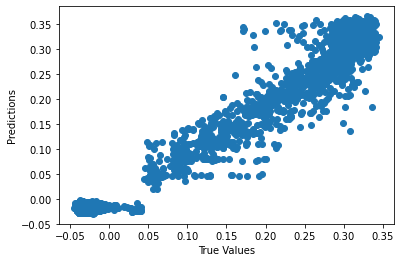

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [94]:
%store model_fl_x

Stored 'model_fl_x' (LinearRegression)


In [54]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
joblib.dump(model_fl_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_x.sav']

## Predict FL foot -> y

### Linear Regression

In [95]:
# Input
#X = np.hstack((X_motion_step_FL[:, :2], np.array([X_motion_step_FL[:, 5]]).T, 
#               X_motion_step_FL[:, 6:8], np.array([X_motion_step_FL[:, 11]]).T, 
#               np.array([X_motion_step_FL[:, 13]]).T, np.array([X_motion_step_FL[:, 16]]).T))
#X = np.hstack((X_motion_step_FL[:, :2], np.array([X_motion_step_FL[:, 5]]).T, 
#               np.array([X_motion_step_FL[:, 13]]).T, np.array([X_motion_step_FL[:, 16]]).T))
#X = np.hstack((X_motion_step_FL[:, :2], np.array([X_motion_step_FL[:, 5]]).T,
#               np.array([X_motion_step[idx_fl_swinging-1, 27]]).T, np.array([X_motion_step[idx_fl_swinging, 29]]).T))

X = np.hstack((X_motion_step_FL[:, :2], 
               np.array([X_motion_step_FL[:, 5]]).T,
               np.array([X_motion_step[idx_fl_swinging-1, 27]]).T, 
               np.array([X_motion_step[idx_fl_swinging, 29]]).T,
               X_motion_step[idx_fl_swinging, 34:36]))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motion_step_FL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_fl_y = LinearRegression()

# Fit the model
model_fl_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9832728195050647
RMSE:  0.013139694685179155
The lowest error is:  1.5032282655452756e-07
The highest error is:  0.13529637646043316
The avg. error is:  0.008384267965829483


Text(0, 0.5, 'Predictions')

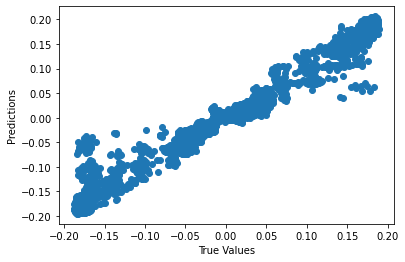

In [96]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [97]:
%store model_fl_y

Stored 'model_fl_y' (LinearRegression)


In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [24]:
# Save model
joblib.dump(model_fl_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_y.sav']